# Problem 3 PS 2
 Muhammad Bashir

In [201]:
# Load Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [202]:
# set paths to working directory 
path = '/Users/muhammadbashir/GitHub/MuhammadCourses/Ec240a/Problem Sets'
# load RPS_calorie_data.out data and read only columns Y0tc and X0te.
calories = pd.read_csv(path + '/RPS_calorie_data.out',usecols=['Y0tc','X0te'])
calories.head()

,Y0tc,X0te
0,9.061790,9.917698
1,7.870896,8.276105
2,8.262976,8.036979
3,9.057076,9.212327
4,8.953918,9.826068


Let \( Y \) denote log calories and \( X \) denote log expenditure. Assume that
\[
m(x) = \mathbb{E}[Y \mid X = x] = \sum_{k=1}^{K} \alpha_k g_k(x),
\]

where \( g_k(x) = x^{k-1} \).

Using the power series basis described above and the Gram-Schmidt algorithm construct a new basis
that is orthogonal to the design points (set \( K = 12 \)). Let \( W_i \) denote the \( K \times 1 \) vector of orthonormal
basis functions for the \( i \)-th household. Compute the least squares fit
\( m (X_i) = W_i^0 \hat{\theta} \)
with
\[
\hat{\theta} =
\left( \sum_{i=1}^{N} W_i W_i^0 \right)^{-1}
\times
\left( \sum_{i=1}^{N} W_i Y_i \right).
\]
Plot this function onto a scatter of the unsmoothed data.


In [203]:
# First create K =12 g functions/polynomials, where g_k(x) = x^k-1 for the column X0te.
K = 12
for k in range(1,K+1):
    calories['X0te_g'+str(k)] = calories['X0te']**(k-1)

Orthogonalize g functions using Gram-Schmidt algoritm

In [204]:

def gram_schmidt_custom_inner_product(X):
    """
    Orthonormalizes the columns of matrix X using the Gram-Schmidt process
    with a custom inner product defined as the mean of the element-wise product.
    
    Parameters:
        X (numpy.ndarray): Input matrix with shape (m, n), where m >= n.
        
    Returns:
        numpy.ndarray: Matrix with orthonormalized columns.
    """
    def custom_inner_product(u, v):
        """Custom inner product: mean of element-wise product."""
        return np.mean(u * v)
    
    # Get the number of rows (m) and columns (n) of X
    m, n = X.shape
    
    # Initialize an empty matrix to store orthonormal vectors
    Q = np.zeros((m, n))
    
    for i in range(n):
        # Start with the current column vector
        v = X[:, i]
        
        # Subtract projections of v onto all previous Q columns
        for j in range(i):
            projection = custom_inner_product(Q[:, j], v) * Q[:, j]
            v -= projection
        
        # Normalize the vector using the custom norm
        v_norm = np.sqrt(custom_inner_product(v, v))
        if v_norm > 1e-10:  # Check to avoid division by zero
            Q[:, i] = v / v_norm
        else:
            raise ValueError(f"Column {i} is linearly dependent on previous columns.")
    
    return Q


# Apply the Gram-Schmidt process to the columns of X0te
X = calories[['X0te_g' + str(k) for k in range(1, K+1)]].values
Q = gram_schmidt(X)
Q.shape


(1358, 12)

Compute least square fit of this orthonormal basis

In [205]:
# Compute the OLS estimates of the coefficients of the K polynomials i.,e regress Y0tc on the K polynomials fk. 
# First create a list of the columns of the data frame that contain the K polynomials.
# X = calories[['X0te_f'+str(k) for k in range(1,13)]]
# X = np.array(X)
X= Q
Y = calories['Y0tc']
Y = np.array(Y)

# Compute the OLS estimates of the coefficients of the K polynomials i.,e regress Y0tc on the K polynomials fk.
beta = (np.linalg.inv(X.T @ X) @ X.T) @ Y
# predict mean by multiplying the estimated coefficients by the polynomials.
calories['Y0tc_hat'] = X @ beta


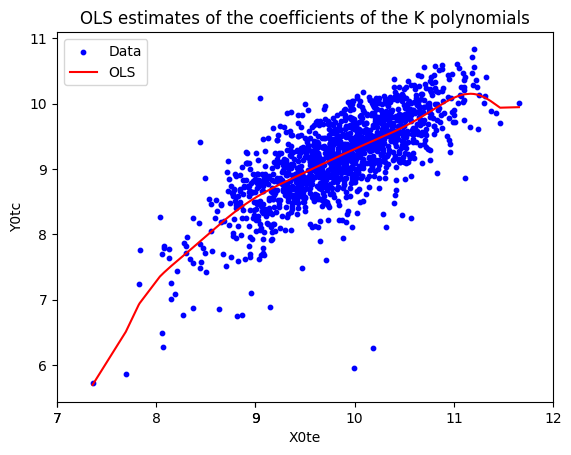

In [206]:

# Plot this function onto a scatter of the unsmoothed data.
plt.scatter(calories['X0te'], calories['Y0tc'], label='Data', color='blue', s=10)
sorted_indices = np.argsort(calories['X0te'])
plt.plot(calories['X0te'].iloc[sorted_indices], calories['Y0tc_hat'].iloc[sorted_indices], label='OLS', color='red')
plt.xlabel('X0te')
plt.ylabel('Y0tc')
plt.legend()
plt.title('OLS estimates of the coefficients of the K polynomials')

# Add 10 equally spaced xticks
xticks = np.linspace(np.floor(calories['X0te'].min()), np.ceil(calories['X0te'].max()), 8)
xticks = xticks.astype(int)
plt.xticks(xticks)

plt.show()

3. Now use the shrinkage estimator of Efromovich (1999) as described in lecture to estimate m (Xi). Plot
this function onto a scatter of the unsmoothed data. Comment on your findings.

In [207]:
# Define Shrinkage constant c as 1-(Sigma^2)/(N*beta^2)
sigma2 = np.var(Y - X @ beta)
N = len(Y)
c = np.zeros(K)
for i in range(K):
    c[i] = 1 - (sigma2 / N) / beta[i]**2
    theta[i] = c[i] * beta[i]
calories['Y0tc_hat_shrink'] = np.dot(X, theta)


### Soft Threshold Estimator 

In [209]:
# First let us choose lambda by minimizing (K/N)*Sigma^2-2(sigma^2/N)Sum1toK(1(abs(theta_k))<=lmabda)+Sum1toK(theta_k^2,lambda^2)
# Define the function that computes the value of the objective function for a given value of lambda.
def objective_function(lmbda, theta, sigma2,K,N):
    return (K/N)*sigma2 - 2*(sigma2/N)*np.sum(np.abs(theta) <= lmbda) + np.sum(np.minimum(theta**2, lmbda**2))
# minimize the objective function over lambda
from scipy.optimize import minimize_scalar
result = minimize_scalar(objective_function, args=(theta, sigma2,K,N))
lmbda = result.x
# Soft thresholding
theta_soft = np.sign(theta) * np.maximum(np.abs(theta) - lmbda, 0)
calories['Y0tc_hat_soft'] = X @ theta_soft


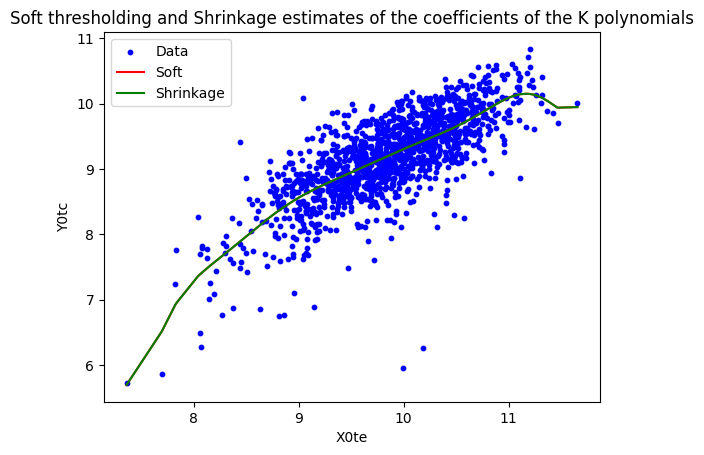

In [211]:
# Plot the soft thresholding estimates of the coefficients of the K polynomials
plt.scatter(calories['X0te'], calories['Y0tc'], label='Data', color='blue', s=10)
sorted_indices = np.argsort(calories['X0te'])
plt.plot(calories['X0te'].iloc[sorted_indices], calories['Y0tc_hat_soft'].iloc[sorted_indices], label='Soft', color='red')
plt.plot(calories['X0te'].iloc[sorted_indices], calories['Y0tc_hat_shrink'].iloc[sorted_indices], label='Shrinkage', color='green')
plt.xlabel('X0te')
plt.ylabel('Y0tc')
plt.legend()
plt.title('Soft thresholding and Shrinkage estimates of the coefficients of the K polynomials')
plt.show()


All three estimators here are the same. Our choice of basis was pretty good and shrinkrage did not change it much. Also in soft threshold lambda is near zero which means we get same estimator back. 